# 1. Kontekst biznesowy, cel, pomiar celu i dane 

## 1.1 Kontekst biznesowy
Chcemy zminimalizować refundację dla szpitali o ponadprzeciętnej readmisji. <br>
Dla tych szpitali, które są obecnie karane w ramach tego programu, jednym z rozwiązań jest stworzenie interwencji w celu zapewnienia dodatkowej pomocy pacjentom o zwiększonym ryzyku readmisji. <br>
Pytanie jednak jest takie: **jak rozpoznać takich pacjentów?** 

## 1.2 Cel dla ML
Chcemy przewidzieć, czy pacjent z cukrzycą zostanie odesłany do szpitala w ciągu 30 dni.<br>
Target w zbiorze danych treningowych i testowych zawarto w kolumnie readmitted. <br>
Wartość readmitted=100 - pacjent wróci w ciagu 30 dni do szpitala <br>
Wartość readmitted=0 pacjent nie wróci wciągu 30 dni di szpitala<br>


## 1.3 Miara
Miarą sukcesu (ang. *success metric*) jest współczynik RMSLE: <br>
$RMSLE=\sqrt{\frac{1}{n}\sum_{i=1}^{n} (log(p_i+1)-log(a_i+1))^2}= \sqrt{\frac{1}{n}\sum_{i=1}^{n} \Big(\log{\frac{p_i+1}{a_i+1}}\Big)^2}$

$a_i$ -wartości rzeczywiste <br>
$p_i$ - wartość predykcji <br>


## 1.4 Kaggle
Konkurs dostępny na Kaggle - link do [konkursu](https://www.kaggle.com/t/5f586fe8eb894a01bdbd4332bbc10d67).

## 1.5 Dane treningowe i testowe
W danych jest **66 221** wierszy, które zostały podzielone prawie na równe cześci:
- train (33 051 wierszy) 
- test (33 170 wierszy) - to trochę większy zbiór niż testowy, więc trzeba będzie spojrzeć na krzywą uczenia

## 1.6 Zmienne
- **encounter_id** - Unikalny identyfikator spotkania.
- **patient_nbr** - Unikalny identyfikator pacjenta
- **race** - Rasa
- **gender** - Płeć
- **age** - Wiek pogrupowany w 10-letnich interwałach
- **weight** - Waga w funtach
- **admission_type_id** - Cyfrowy identyfikator rodzaju przyjęcia do szpitala (np. "awaryjny", "nowo narodzony" itp.)
- **discharge_disposition_id** - Cyfrowy identyfikator rodzaju wypisania ze szpitala (np. "przeterminowane", "zwolniony do domu" itp.)
- **admission_source_id** - Cyfrowy identyfikator źródła wizyty (np. "transfer z innego szpitala", "skierowanie od lekarza" itp.)
- **time_in_hospital** - Czas w szpitalu w dniach
- **payer_code** - Identyfikator rodzaju płatności (np. czy pacjent sam płacił albo czy miał ubezpieczenie w Blue Cross/Blue Shield itp.)
- **medical_specialty** - Specjalizacja lekarza, który przyjął pacjenta
- **num_lab_procedures** - Ilość testów laboratoryjnych przeprowadzonych w trakcie spotkania
- **num_procedures** - Ilość procedur (innych, niż testy laboratoryjne) przeprowadzonych w trakcie spotkania
- **num_medications** - Ilość unikalnych lekarstw podanych w trakcie spotkania
- **number_outpatient** - Ilość wizyt ambulatorium przez pacjenta w ciągu roku poprzedzającego spotkanie
- **number_emergency** - Ilość awaryjnych (ang. emergency) wizyt pacjenta w ciągu roku poprzedzającego spotkanie
- **number_inpatient** - Ilość hospitalizowanych wizyt pacjenta w ciągu roku poprzedzającego spotkanie
- **diag_1** - Pierwotna diagnoza (oznaczona jako 3 pierwsze cyfry wg standardu ICD9)
- **diag_2** - Wtórna diagnoza (oznaczona jako 3 pierwsze cyfry wg standardu ICD9)
- **diag_3** - Dodatkowa wtórna diagnoza (oznaczona jako 3 pierwsze cyfry wg standardu ICD9)
- **number_diagnoses** - Ilość diagnoz wprowadzona do systemu
- **max_glu_serum** - Wynik badań na glukozę.
- **A1Cresult** - Wynik badania A1c. ">8" jeśli wynik był większy, niż 8%, ">7" jeśli wynik był większy, niż 7%, ale mniejszy, niż 8%. "normal" jeśli wynik jest mniejszy, niż 7%
- **change** - Informacja, czy była zmiana w lekarstwach (zarówno dawka, jak i rodzaj leku)
- **diabetesMed** - Informacja, czy była recepta na dowolne lekarstwa na cukrzycę
- 24 kolumny z nazwami lekarstw (**metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone**) - Mówi o tym czy dawka na dane lekarstwo została zwiększona, zmniejszona, czy pozostała bez zmian, lub czy w ogóle nie było recepty na to lekarstwo
- **readmitted** - Czy w ciągu 30 dni pacjent był ponownie skierowany do hospitalizacji
- **id** - Unikalne id obserwacji (potrzebne do Kaggle)

# 2. Pobranie bibliotek

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2019)
import sklearn
import math

import gc

# biblioteka do miary sukcesu
from ml_metrics import rmsle 

# biblioteba wykorzystana przy budowie krzywej uczenia
from sklearn.model_selection import learning_curve

#biblioteki walidacji 
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#podział zbiorów na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split  #, cross_val_score, GridSearchCV

# Bibloteka do utworzenia funkcji dla score przy rysowaniu learning_curve
from sklearn.metrics import make_scorer #, jaccard_similarity_score 

# biblioteki do predykcji 
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

#biblioteka do badania wżności cech danego modelu
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
from eli5.permutation_importance import get_score_importances

# bilioteka do podziału zbioru X,y na podzbiór treningowy i testowy 
from sklearn.model_selection import train_test_split


#biblioteka wykorzystywana  KFold - postęp w zadaniu
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,4)
import seaborn as sns

%matplotlib inline
pd.options.display.max_columns = 1_000
pd.options.display.max_rows = 1_000

Using TensorFlow backend.


# 3 Pobranie danych

Pobranie danych treningowych ze źródła

In [2]:
train = pd.read_hdf('../input/diabetic_train.h5')

Pobranie danych testowych ze źródła

In [3]:
test = pd.read_hdf('../input/diabetic_test.h5')

Połaczenie (konkatenacja) zbiorów poprzez dodanie wierszy

In [4]:
df_all = pd.concat ([train, test])

Usuniecie zbiorów których nie będziemy używać

In [5]:
del  train, test

Czyścimy pamięć

In [6]:
gc.collect()

148

Rzut oka na pobrane dane 

In [7]:
df_all.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,0
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,0,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,0,3
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,4
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,8


# 4. Pierwsze próby uruchomienia różnych modeli

## 4.1 Przygotowanie zbioru treningowego

Sprawdzamy format danych 

In [8]:
# X_df.info()

Tworzymy listę zmiennych, których nie będziemy używaż w modelu

In [9]:
feats= df_all.select_dtypes(include=np.number).columns
black_list=['id', 'readmitted']
feats=[feat for feat in feats if feat not in black_list]

Tworzymy po raz pierwszy zbiór treningowy

In [10]:
train=df_all[df_all.readmitted !=''].copy()
X_df=train[feats]
X=X_df.values
y=train['readmitted'].values.astype(np.int8)

## 4.2 Lista modeli, kótrymi będziemy się zajmować

Tworzymy listę modeli na które będziemy uruchamiali

In [11]:
models = [
        xgb.XGBClassifier(random_state=2019,max_depth=7, n_estimators=300, objective='binary:logistic'),
        DecisionTreeClassifier(max_depth=10,random_state=2019),
        AdaBoostClassifier(random_state=2019),
        BaggingClassifier(random_state=2019),
        LogisticRegression(random_state=2019,solver='lbfgs'),
        DecisionTreeClassifier(random_state=2019),
        DecisionTreeRegressor(random_state=2019, max_depth=5),
        RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=5,random_state=2019),
        ExtraTreesClassifier(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=5,random_state=2019),
        ]        

## 4.3 Pierwsze modelowanie

Przygotujmy funkcje, do uruchamiania poszczególnych modeli z wykorzystaniem KFold <br>
Docelowo wybieramy przy trenowaniu StratifiedKFold  - modelu model_train_predict2

In [12]:
KFold_split=3
def model_train_predict(model, X, y, success_metric=rmsle):
    cv = KFold(n_splits=KFold_split, random_state=2019, shuffle=True) 
    scores =[]     
    for train_idx, test_idx in cv.split(y): 
        model.fit(X[train_idx], y[train_idx]) 
        y_pred = model.predict(X[test_idx]) 
        score =success_metric(y[test_idx], y_pred )
        scores.append(score)
        print(i,'rmsle=',score)    
    
    print(i, 'średnie rmsle=', np.mean(scores), 'odchylenie standardowe (std)=' , np.std(scores), model)  

    
def model_train_predict2(model, X, y, success_metric=rmsle):
    cv = StratifiedKFold(n_splits=KFold_split, random_state=2019, shuffle=True) 
    scores =[]     
    for train_idx, test_idx in cv.split(X,y):
        X_fold_train, X_fold_test=X[train_idx], X[test_idx]
        y_fold_train, y_fold_test=y[train_idx], y[test_idx]
        model.fit(X_fold_train, y_fold_train)
        
        y_pred=model.predict(X_fold_test) 
        score =success_metric(y[test_idx], y_pred )
        scores.append(score)
        print(i,'rmsle=',score)    
    
    print(i, 'średnie rmsle=', np.mean(scores), 'odchylenie standardowe (std)=' , np.std(scores), model) 

Uruchamiamy modele i patrzymy na wyniki

In [13]:
for i in range(0, len(models)):
    print("start model nr:", i)
    model_badany=models[i]
    model_train_predict(model_badany, X, y)

start model nr: 0
0 rmsle= 1.92
0 rmsle= 1.865
0 rmsle= 1.859
0 średnie rmsle= 1.882 odchylenie standardowe (std)= 0.02727 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
start model nr: 1
1 rmsle= 1.979
1 rmsle= 1.922
1 rmsle= 1.927
1 średnie rmsle= 1.942 odchylenie standardowe (std)= 0.02562 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
    

## 4.4 Zgrubna, wstępna ocena modeli

Model nr 0: **XGBClassifier**, wygląda na razie najbarciej obiecująco (dobry wynik przy małym odchyleniu)<br>
średni score:  **1.882** odchylenie standardowe (std):  **0.02727**

# 5. CYKLICZNIE - analiza zmiennych, dodawnie nowych zmiennych, badanie wyników 
Teraz rozpoczynamy żmudny cykl analizy zmiennych, budowania nowych zmiennych i badania ich wplywu na wynik. 

Po dodaniu nowej zmiennej powtarzamy kolejno punkty 5.2, 5.3 , 6 od początku.<br>
W zakomentowanych poniżej fragmentach zmienne były odrzucane <br>


## 5.1 Analiza zmiennych

Na wszelki wypadek wczytujemy zbiór ponownie 

In [14]:
feats= df_all.select_dtypes(include=np.number).columns
black_list=['id', 'readmitted']
feats=[feat for feat in feats if feat not in black_list]

train=df_all[df_all.readmitted !=''].copy()
X_train=train[feats].values
y_train=train['readmitted'].values.astype(np.int8)

### 5.1.2 Do oceny ważnosci cech wykorzystamy bibliotekę eli5 (ang. Explain Like I'm Five)
Weźmiemy model XGBClassifier i zbadajmy co podpowie nam eli5

Dzielimy nasz zbiór na dwa podzbiory: testowy i tereningowy:

In [15]:
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, shuffle=True, random_state=0)


Trenujemy model XGBClassifier na zbirze treningowym (dodtkowo sprawdzamy czas działania przez dodanie %time

In [16]:
%time model =xgb.XGBClassifier(random_state=2019,max_depth=7, n_estimators=300, objective='binary:logistic').fit(X_sub_train, y_sub_train)

CPU times: user 14.8 s, sys: 0 ns, total: 14.8 s
Wall time: 14.8 s


Teraz stosujemy **PermutationImportance** na zbiorze testowym.<br>
**PermutationImportance** polega z grubsza na tym, że bierzemy jakąś cechę i 
dokonujemy mieszania wartości w kolumnie danej cechy. <br>
Nową tablicę ze zmienionymi wartościami poddajemy działaniu modelu i sprawdzamy czy wynik sie pogorszył.<br>
Jeśli wynik nie pogorszył sie, to cecha może być losowa i wynik w rankingu będzie niski;
a jeśli wynik permutacji sie pogorszył, to cecha moze być ważna

In [17]:
%time perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)

CPU times: user 28.2 s, sys: 21.3 ms, total: 28.2 s
Wall time: 28.2 s


W zmiennej **eli_show0** przechowujemy miłą dla oka prezentację ważności 50 najlepszych cech:

In [18]:
eli_show0=eli5.show_weights(perm, feature_names=feats, top=50)

W zmiennej **df_eli0** przechowujemy DataFrame utworzonego z tabeli ważnosci cech, aby później wygodniej posługiwać się przy wykorzystaniu listy cech najlepszych

In [19]:
df_eli0=eli5.explain_weights_df (perm, feature_names=feats, top=50)

Zobaczmy jak wyglada ranking cech <br>
Uwaga: w nazwie **eli_show0** podałem 0 bo badałem ważność cech dla innych modeli, <br>
ale by ograniczyć ten skrypt ograniczyłem sie do modelu nr 0 tj. XGBClassifier )

In [20]:
eli_show0

Weight,Feature
0.0210 ± 0.0031,number_inpatient
0.0079 ± 0.0018,discharge_disposition_id
0.0073 ± 0.0034,encounter_id
0.0065 ± 0.0014,patient_nbr
0.0021 ± 0.0010,number_emergency
0.0007 ± 0.0006,insulin
0.0007 ± 0.0013,admission_type_id
0.0007 ± 0.0028,num_medications
0.0005 ± 0.0014,num_procedures
0.0005 ± 0.0016,num_lab_procedures


Widać, że są 4 cechy wyrżniające się: <br>
0.0211 ± 0.0016	**number_inpatient**<br>
0.0077 ± 0.0040	**encounter_id**<br>
0.0077 ± 0.0016	**discharge_disposition_id**<br>
0.0066 ± 0.0030	**patient_nbr**<br>
Poszukajmy jakiegoś głębszego sensu w tych zmiennych tworząc nowe zmienne i ich kombinacje.

## 5.2. Nowe zmienne

### 5.2.1 Nowe zmienne na podstawie <i>number_inpatien</i>
    

Najbardziej oczywiste zmienne na podstawie **number_inpatien**

In [21]:
df_all["number_inpatien_count"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('count')
df_all["number_inpatien_avg"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('mean')
df_all["number_inpatien_min"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('min')
df_all["number_inpatien_max"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('max')
df_all["number_inpatien_sum"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('sum')
df_all["number_inpatien_median"] = df_all.groupby(["patient_nbr"])['number_inpatient'].transform('median')

df_all["number_return_year"] =df_all["number_inpatien_max"] - df_all["number_inpatien_min"]
# df_all["number_return_mean_month"] =df_all["number_return_year"]/12
# df_all.info()

### 5.2.2 Nowa zmienna na podstawie <i>encounter_id</i>
Nową zmienną utworzymy jako różnicę pomiędzy kolejnymi identyfikatorami **encounter_id** dla każdego pacjenta. <br>
Ta nowa zmienna będzie miała sens jeżeli <br>
- **encounter_id** nadawane są kolejno, co wydaje sie sensowne, bo jak porównamy dla jakiegoś pacjenta (np dla patient_nbr=103140) zmienne **encounter_id** i **number_diagnoses**, to gdy    **encounter_id** rośnie, to **number_diagnoses** rośnie<br>
- pacjenci są przyjmowani do szpitala w tym samym tempie, co wydaje się także słuszne bo każdy szpital ma ograniczoną liczbę miejsc, 
  a więc średnie tempo przyjęć do szpitala będzie stałe. <br>

Nowa mienna będzie zatem odzwieciedlała liniową miarę czasu (mierzonego co prawda nie w dniach ani w godzinach, ale w nowej jesdnostce nazwijmy ją **encounter_id_diff**).

Zmienną **encounter_id_diff** obliczmy różnicę pomiędzy rosnącymi wartościmi encounter_id dla każdego pacjenta 

In [22]:
b=df_all[['patient_nbr','encounter_id']].copy()
b.sort_values(by =['patient_nbr','encounter_id'], inplace =True)
b['encounter_id_diff'] = b.groupby('patient_nbr')['encounter_id'].diff().fillna(0).astype("int64")
df_all = pd.merge(df_all, b,  how='left', on=('patient_nbr','encounter_id'))

Sprawdźmy na jednym pacjencie (przykładowo, dla patient_nbr=103140) jak wyglada wynik:

In [23]:
# a=df_all[df_all["patient_nbr"]==103140]
# a

### 5.2.3 Nowa zmienna na podstawie <i>discharge_disposition_id</i>

Pobieramy słowniki z pliku **ids_mapping.csv**

In [24]:
mapowanie= pd.read_csv('../../module3/input/ids_mapping.csv')
admission_type_map = mapowanie[:8]
discharge_type_map = mapowanie[10:40]
admission_source_map = mapowanie[42:]
discharge_type_map.columns = ['discharge_disposition_id','description']
admission_source_map.columns = ['admission_source_id', 'description']

In [25]:
discharge_type_map

,discharge_disposition_id,description
10,1,Discharged to home
11,2,Discharged/transferred to another short term h...
12,3,Discharged/transferred to SNF
13,4,Discharged/transferred to ICF
14,5,Discharged/transferred to another type of inpa...
15,6,Discharged/transferred to home with home healt...
16,7,Left AMA
17,8,Discharged/transferred to home under care of H...
18,9,Admitted as an inpatient to this hospital
19,10,Neonate discharged to another hospital for neo...


Tu nie wiele wiem, i tylko mogę intuicyjnie podejrzewać związki

Wykres słupkowy dla  **discharge_disposition_id**

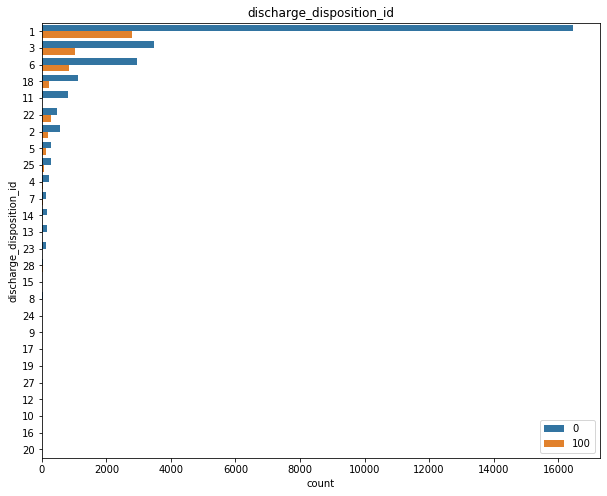

In [26]:
for i in train[['discharge_disposition_id']].columns:
    fig = plt.figure(figsize = (10, 8))
    sns.countplot(y = train[i], hue = train.readmitted, order = train[i].value_counts().index)
    plt.title(i)
    plt.legend(loc = "lower right")
    plt.show()

Wykres ciągły dla  **discharge_disposition_id**

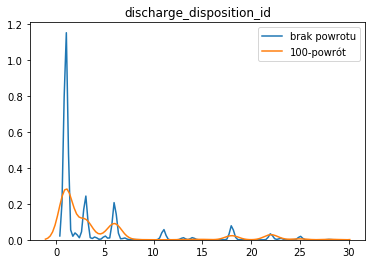

In [27]:
for j in train[['discharge_disposition_id']].columns:
    sns.kdeplot(train.loc[train.readmitted == 0, j])
    sns.kdeplot(train.loc[train.readmitted == 100, j])
    plt.title(j)
    plt.legend(['brak powrotu', '100-powrót'])
    plt.show()

Spróbójmy takiego mapowania (trudno mi jakoś sensownie wyjaśnić dlaczego - chciałem grupować cechy, które różnicują podobnie):

In [28]:
df_all["discharge_disposition_id2"]=df_all["discharge_disposition_id"].replace([18,25,26],0) 
df_all["discharge_disposition_id2"]=df_all["discharge_disposition_id"].replace([1,6,8,13,14],1) 
df_all["discharge_disposition_id2"]=df_all["discharge_disposition_id"].replace([2,3,4,5],2) 
df_all["discharge_disposition_id2"]=df_all["discharge_disposition_id"].replace([9,10,12,13,14,15,16,17,22,23,24],3)
df_all["discharge_disposition_id2"]=df_all["discharge_disposition_id"].replace([11,19,20,21],4) 

### 5.2.4 Nowe zmienne na podstawie <i>patient_nbr</i>

Liczba występowania danego pacjenta w tabeli 

In [29]:
df_all['liczba']=1
df_all["liczba_powrotow"] = df_all.groupby(["patient_nbr"])['liczba'].transform('sum')
a=df_all[df_all["patient_nbr"]==103140]
# df_all.info()
# a

Pacjenci powracający

In [30]:
duplicates = df_all[df_all.copy().patient_nbr.isin(df_all.patient_nbr[df_all.patient_nbr.duplicated()])].sort_values(by = 'patient_nbr')
duplicates['duplikat']=1
duplikates2=duplicates[['patient_nbr','duplikat']].drop_duplicates()

# print(duplikates2.info())

df_all=pd.merge(df_all, duplikates2,  how='left', on='patient_nbr')
df_all['duplikat'] =df_all['duplikat'].fillna(0).astype("int8")
# df_all.info()

Jeszcze kilka prób utworzenia zmiennych z udziałem **patient_nbr**

In [31]:
columny1=["time_in_hospital","num_lab_procedures","num_procedures","num_medications" ]
for col in columny1:
    grouping1 = df_all.groupby(["patient_nbr"])[col]
    df_all[col+'_sum_all'] = grouping1.transform(sum).astype("int64")

columny2=["number_diagnoses","number_outpatient","number_emergency","number_inpatient","max_glu_serum_dic"]
for col in columny1:
    grouping1 = df_all.groupby(["patient_nbr"])[col]
    df_all[col+'_max'] = grouping1.transform(max).astype("int64")
   
    
columny3=["number_diagnoses"]
for col in columny1:
    grouping1 = df_all.groupby(["patient_nbr"])[col]
    df_all[col+'_min'] = grouping1.transform(min).astype("int64")
 

### 5.2.5 Nowe zmienne na podstawie <i>number_outpatient</i> i  <i>number_emergency</i>
Zmienne nie przyniosły (po weryfikacji) wkładu w wynik, a więc zostały usuniete z badania

In [32]:
# df_all["number_outpatient_count"] = df_all.groupby(["patient_nbr"])['number_outpatient'].transform('count')
# df_all["number_outpatient_avg"] = df_all.groupby(["patient_nbr"])['number_outpatient'].transform('mean')
# df_all["number_outpatient_min"] = df_all.groupby(["patient_nbr"])['number_outpatient'].transform('min')
# df_all["number_outpatient_max"] = df_all.groupby(["patient_nbr"])['number_outpatient'].transform('max')
# df_all["number_outpatient_max"] = df_all.groupby(["patient_nbr"])['number_outpatient'].transform('sum')
# df_all["number_outpatient_median"] = df_all.groupby(["patient_nbr"])['number_outpatient'].transform('median')

# df_all["number_emergency_avg"] = df_all.groupby(["patient_nbr"])['number_emergency'].transform('count')
# df_all["number_emergency_avg"] = df_all.groupby(["patient_nbr"])['number_emergency'].transform('mean')
# df_all["number_emergency_min"] = df_all.groupby(["patient_nbr"])['number_emergency'].transform('min')
# df_all["number_emergency_max"] = df_all.groupby(["patient_nbr"])['number_emergency'].transform('max')
# df_all["number_emergency_max"] = df_all.groupby(["patient_nbr"])['number_emergency'].transform('sum')
# df_all["number_emergency_median"] = df_all.groupby(["patient_nbr"])['number_emergency'].transform('median')

### 5.2.6 Jeszcze kilka prób utworzenia nowych ziennych 

Liczba wizyt ambulatoryjnych i szpitalnych:<br>
**number_outpatient** - Ilość wizyt ambulatorium przez pacjenta w ciągu roku poprzedzającego spotkanie<br>
**number_inpatient** - Ilość hospitalizowanych wizyt pacjenta w ciągu roku poprzedzającego spotkanie<br>

In [33]:
df_all["liczba_wizyt_outpatient_inpatient"]=df_all[['number_outpatient','number_inpatient']].sum(axis=1)
df_all["liczba_wizyt_number_emergency_inpatient"]=df_all[['number_emergency','number_inpatient']].sum(axis=1)

Udzial_Emergency_LabProcedures_Medications = number_emergency/(num_lab_procedures+num_medications)

In [34]:
df_all["udzial_Emergency_LabProcedures_Medications"]=df_all["number_emergency"]/(df_all["num_lab_procedures"]+df_all["num_medications"])
# df_all[['number_emergency', 'num_lab_procedures','num_medications',"udzial_Emergency_LabProcedures_Medications"]].head(10)
# df_all[['number_outpatient', 'number_inpatient',"liczba_wizyt_outpatient_inpatient"]].head()

## 5.3 Pouszukiwanie interakcji pomiedzy zmiennymi - do tworzenia nowych zmienych

In [35]:
import xgbfir
xgbfir.saveXgbFI(model,feature_names=feats, OutputXlsxFile='diabets.xlsx')
pd.read_excel('diabets.xlsx','Interaction Depth 2').head(15)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,discharge_disposition_id|number_inpatient|numb...,7258.949107,19,4.095230,0.215538,382.049953,2529.235650,1,72,19,8,1,1,17.000000,6.894737,2.263158
1,number_inpatient|number_inpatient|number_inpat...,5221.086679,14,1.915100,0.136793,372.934763,666.487777,2,88,45,15,2,4,26.000000,6.500000,2.000000
2,discharge_disposition_id|number_emergency|numb...,3976.348135,45,7.564549,0.168101,88.363292,973.979879,3,24,5,13,12,2,9.833333,11.244444,3.044444
3,number_emergency|number_inpatient|number_inpat...,3493.298125,16,2.206206,0.137888,218.331133,585.073058,4,84,36,14,4,5,24.500000,11.312500,2.250000
4,encounter_id|patient_nbr|patient_nbr,2967.755690,179,19.230996,0.107436,16.579641,336.107381,5,1,2,24,38,8,13.000000,36.307263,5.083799
5,discharge_disposition_id|number_inpatient|pati...,2754.657299,28,2.979197,0.106400,98.380618,554.950393,6,47,26,26,10,6,20.166667,18.928571,3.392857
6,encounter_id|encounter_id|patient_nbr,2398.791772,158,11.274469,0.071357,15.182226,178.131941,7,2,4,42,46,13,19.000000,39.765823,5.094937
7,discharge_disposition_id|encounter_id|patient_nbr,2370.455350,111,5.111051,0.046046,21.355454,123.711130,8,3,11,62,29,18,21.833333,23.828829,4.774775
8,number_inpatient|number_inpatient|patient_nbr,2342.082183,14,1.180033,0.084288,167.291584,212.737027,9,89,66,32,7,11,35.666667,19.714286,3.071429
9,discharge_disposition_id|discharge_disposition...,2195.039145,81,4.282324,0.052868,27.099249,143.317478,10,9,17,57,22,17,22.000000,20.765432,5.098765


Poniżej próby (niezbyt doskonałe) łaczenia zmiennych. <br> 
Te nowe zmienne, które nic nie dały w wyniku zostały zamarkowane # (mogłem je w sumie usunąć, ale wtedy nie pamietałbym czy je brałem czy nie )

In [36]:
# df_all['concat1']=df_all['liczba_powrotow'] + df_all['number_inpatient'] 
df_all['concat2']=df_all['liczba_powrotow'] + df_all['liczba_powrotow'] +df_all['number_inpatient'] 
df_all['concat3']=df_all['liczba_powrotow'] * df_all['number_inpatient'] 
# df_all['concat4']=np.exp(df_all['liczba_powrotow']).astype("int64")  
# df_all['concat7']=df_all['liczba_powrotow'] | df_all['number_inpatient']  |df_all['number_inpatient'] 
# df_all['concat3']=df_all['number_inpatient'] + df_all['patient_nbr'] 
df_all['concat8']=df_all['liczba_powrotow'] * df_all['num_lab_procedures_sum_all'] 
# df_all['concat9']=df_all['number_inpatient'] | df_all['time_in_hospital_avg_all'] 
# df_all['concat7']=df_all['liczba_powrotow'] | df_all['number_inpatien_avg'] 

## 5.4 Ponownie badamy ważność cech  z eli5

In [37]:
feats= df_all.select_dtypes(include=np.number).columns
black_list=['id', 'encounter_id', 'patient_nbr','readmitted']
feats=[feat for feat in feats if feat not in black_list]

train=df_all[df_all.readmitted !=''].copy()
X_df=train[feats]
X_train=X_df.values
y_train=train['readmitted'].values.astype(np.int8)

In [38]:
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, shuffle=True, random_state=0)
model =xgb.XGBClassifier(random_state=2019,max_depth=7, n_estimators=300, objective='binary:logistic').fit(X_sub_train, y_sub_train)
%time perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)
eli_show0=eli5.show_weights(perm, feature_names=feats, top=50)
df_eli0=eli5.explain_weights_df (perm, feature_names=feats, top=50)

CPU times: user 47.9 s, sys: 51.7 ms, total: 47.9 s
Wall time: 47.9 s


In [39]:
eli_show0

Weight,Feature
0.0808 ± 0.0028,number_inpatien_count
0.0577 ± 0.0017,number_inpatient
0.0506 ± 0.0034,concat2
0.0110 ± 0.0008,encounter_id_diff
0.0064 ± 0.0019,number_inpatien_sum
0.0044 ± 0.0007,number_inpatien_max
0.0025 ± 0.0008,number_inpatien_avg
0.0022 ± 0.0011,discharge_disposition_id
0.0016 ± 0.0007,discharge_disposition_id2
0.0010 ± 0.0006,number_inpatien_median


# 6. Uruchamiamy model, na najlepszych zmiennych 

## 6.1 Ustawienie parametrów

Ustawiam ile cech powinienem bać do modelu z listy wskazanej przez eli5 - biorę 8 cech <br>
Sugeruję się zarówno wartością jak i odchyleniem, ale też na wszelki wypadek stosuję testowanie na różnych kombinacjach cech.

In [40]:
futures_eli0=list(df_eli0['feature'][0:8])
feats=futures_eli0
print(feats)

['number_inpatien_count', 'number_inpatient', 'concat2', 'encounter_id_diff', 'number_inpatien_sum', 'number_inpatien_max', 'number_inpatien_avg', 'discharge_disposition_id']


## 6.2 Przygotowanie danych 

Tworzę na nowo listę z wykluczonymi zmiennymi, dodaję jednak do listy dodatkowo **encounter_id**, **patient_nbr** 
bo zmienne te mają duże odchylenia na liście **eli_show0**

In [41]:
feats= df_all[futures_eli0].select_dtypes(include=np.number).columns
black_list=['id', 'encounter_id', 'patient_nbr','readmitted']
feats=[feat for feat in feats if feat not in black_list]

train=df_all[df_all.readmitted !=''].copy()
X_df=train[feats]
X_train=X_df.values
y_train=train['readmitted'].values.astype(np.int8)

test = df_all[df_all.readmitted==''].copy()
# print( test.info() )
X_df_test=test[feats]
X_test=X_df_test.values

Rzut oka czy wszystko jest w porządku z danymi

In [42]:
# X_df_test.info()
# X_df.info()

## 6.3 Trenowanie modelu

Wybieramy z listy modeli model nr **0** czyli **XGBClassifier**

In [43]:
i=0
model_badany=models[i]

Ustawiam split (w wyniku na Kagle przyjąłem 50)

In [44]:
KFold_split=50

Trenujemy model nr 0 tj. **xgb.XGBClassifier** i walidujemy go z wykorzystaniem **StratifiedKFold** - wszystko zawarte w jednej funkcji **model_train_predict2**

In [45]:
model_train_predict2(model_badany, X_train, y_train)

0 rmsle= 1.354
0 rmsle= 1.2295
0 rmsle= 1.202
0 rmsle= 1.045
0 rmsle= 1.28
0 rmsle= 1.268
0 rmsle= 1.216
0 rmsle= 1.365
0 rmsle= 1.306
0 rmsle= 1.134
0 rmsle= 1.189
0 rmsle= 1.306
0 rmsle= 1.255
0 rmsle= 1.33
0 rmsle= 1.268
0 rmsle= 1.2295
0 rmsle= 1.202
0 rmsle= 1.176
0 rmsle= 1.317
0 rmsle= 1.317
0 rmsle= 1.242
0 rmsle= 1.23
0 rmsle= 1.217
0 rmsle= 1.163
0 rmsle= 1.19
0 rmsle= 1.269
0 rmsle= 1.106
0 rmsle= 1.243
0 rmsle= 1.3545
0 rmsle= 1.217
0 rmsle= 1.178
0 rmsle= 1.257
0 rmsle= 1.121
0 rmsle= 1.231
0 rmsle= 1.218
0 rmsle= 1.205
0 rmsle= 1.231
0 rmsle= 1.244
0 rmsle= 1.319
0 rmsle= 1.218
0 rmsle= 1.244
0 rmsle= 1.257
0 rmsle= 1.27
0 rmsle= 1.332
0 rmsle= 1.295
0 rmsle= 1.257
0 rmsle= 1.257
0 rmsle= 1.178
0 rmsle= 1.178
0 rmsle= 1.257
0 średnie rmsle= 1.239 odchylenie standardowe (std)= 0.06476 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_dept

## 6.4 Uruchomienie modelu na zbiorze testowym

In [46]:
y_pred= model_badany.predict(X_test)

## 6.5 Eksport wyniku na zbiorze testowym do csv

In [47]:
test['readmitted']=y_pred
# print(y_pred)
test[ ['id','readmitted'] ].to_csv('../output/XGBClassifier_final.csv', index=False)

## 6.6 Rzut oka na krzywą uczenia

In [48]:
def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
                    model, X, y, 
                    cv=cv, 
                    n_jobs=n_jobs, 
                    train_sizes=train_sizes, 
                    scoring=make_scorer(rmsle, greater_is_better=False)
                    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

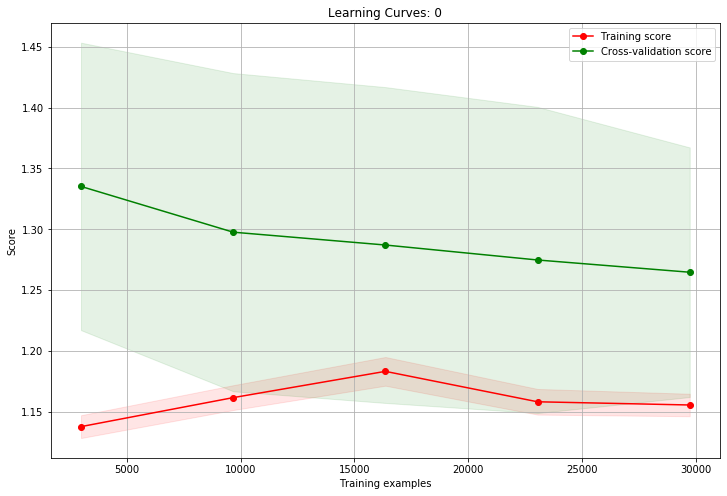

In [49]:
plt = plot_learning_curve(model_badany,"Learning Curves: " + str(i).split('(')[0], X_train, y_train, cv=10, n_jobs=1)
plt.show()

Krzywe uczenia pokazują, że na większym zbiorze możemy spodziewać się nieznacznie lepszego wyniku przy większej liczbie rekordów (obie krzywe treningowa i testowa są malejące i wolno zbliżają się do siebie). I faktycznie, na zbiorze treningowym (33 051 wierszy) dostaliśmy (jak obliczyliśmy powyżej) wyżej wynik **rmsle= 1.239**, a na Kagle (gdzie było wiecej danych testowych - 33170 wierszy) wynik:  **rmsle=1.22279**. Wynik na zbiorze testowym mieści sie w granicach wyliczonego błędu **std= 0.06476**